In [191]:
import pandas as pd
import numpy as np
pd.set_option('max.rows',200)
import time

## Train & Evaluate Model in US

### Load data

In [192]:
train = pd.read_csv('../data/processed/us-train.csv')
val = pd.read_csv('../data/processed/us-val.csv')
us = pd.read_csv('../data/processed/us-test.csv')

In [193]:
y_train = train.log_price
y_val = val.log_price

In [194]:
X_train = train.drop(columns=['log_price'])
X_val = val.drop(columns=['log_price'])

In [195]:
X_train_mean = X_train.copy().mean()
X_train_stdev = X_train.copy().std()

# standardize data
X_train = (X_train - X_train_mean)/X_train_stdev
X_val = (X_val - X_train_mean)/X_train_stdev

In [196]:
X_train.fillna(0, inplace=True)
X_train.replace([np.inf, -np.inf], 0, inplace=True)
X_val.fillna(0, inplace=True)
X_val.replace([np.inf, -np.inf], 0, inplace=True)

### Train Random Forest

### Default Parameters

In [159]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

In [152]:
rf = RandomForestRegressor().fit(X_train, y_train)

In [153]:
y_pred_train = rf.predict(X_train)
y_pred = rf.predict(X_val)

acc_train = rf.score(X_train, y_train)
acc = rf.score(X_val, y_val)

rmse_train = mean_squared_error(np.exp(y_train), np.exp(y_pred_train), squared=False)
rmse = mean_squared_error(np.exp(y_val), np.exp(y_pred), squared=False)

mae_train = mean_absolute_error(np.exp(y_train), np.exp(y_pred_train))
mae = mean_absolute_error(np.exp(y_val), np.exp(y_pred))

medae_train = median_absolute_error(np.exp(y_train), np.exp(y_pred_train))
medae = median_absolute_error(np.exp(y_val), np.exp(y_pred))

In [154]:
print('R^2 (Train):', round(acc_train,2)) 
print('R^2 (Val):', round(acc,2))
print('')
print('RMSE (Train):', round(rmse_train,2))
print('RMSE (Val):', round(rmse,2))
print('')
print('Mean Abs Error (Train):', round(mae_train,2))
print('Mean Abs Error (Val):', round(mae,2))
print('')
print('Median Absolute Error (Train):', round(medae_train,2))
print('Median Absolute Error (Val):', round(medae,2))

R^2 (Train): 0.95
R^2 (Val): 0.68

RMSE (Train): 58.55
RMSE (Val): 116.02

Mean Abs Error (Train): 21.58
Mean Abs Error (Val): 51.73

Median Absolute Error (Train): 8.49
Median Absolute Error (Val): 23.77


### Random Search Parameters

In [9]:
from sklearn.model_selection import RandomizedSearchCV

In [10]:
# rf parameters input into random search
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# produce random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [11]:
# random search best hyper parameters of model
rf_r = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_r, param_distributions = random_grid, n_iter = 20, cv = 5, 
                               verbose=2, random_state=0, n_jobs = -1)

In [12]:
# fit the random search model on 3 cross validations with 20 iters each
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 122.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 323.1min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=0, verbose=2)

In [13]:
# get best random search parameters
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [33]:
rf_opt = RandomForestRegressor(n_estimators=800, min_samples_split=2, 
                                min_samples_leaf=2, max_features='auto',
                               max_depth=100, bootstrap=True).fit(X_train, y_train)

In [34]:
y_pred_train = rf_opt.predict(X_train)
y_pred = rf_opt.predict(X_val)

acc_train = rf.score(X_train, y_train)
acc = rf.score(X_val, y_val)

rmse_train = mean_squared_error(np.exp(y_train), np.exp(y_pred_train), squared=False)
rmse = mean_squared_error(np.exp(y_val), np.exp(y_pred), squared=False)

mae_train = mean_absolute_error(np.exp(y_train), np.exp(y_pred_train))
mae = mean_absolute_error(np.exp(y_val), np.exp(y_pred))

medae_train = median_absolute_error(np.exp(y_train), np.exp(y_pred_train))
medae = median_absolute_error(np.exp(y_val), np.exp(y_pred))

In [35]:
print('R^2 (Train):', round(acc_train,2)) 
print('R^2 (Val):', round(acc,2))
print('')
print('RMSE (Train):', round(rmse_train,2))
print('RMSE (Val):', round(rmse,2))
print('')
print('Mean Abs Error (Train):', round(mae_train,2))
print('Mean Abs Error (Val):', round(mae,2))
print('')
print('Median Absolute Error (Train):', round(medae_train,2))
print('Median Absolute Error (Val):', round(medae,2))

R^2 (Train): 0.95
R^2 (Val): 0.68

RMSE (Train): 69.97
RMSE (Val): 115.75

Mean Abs Error (Train): 24.7
Mean Abs Error (Val): 51.38

Median Absolute Error (Train): 9.26
Median Absolute Error (Val): 23.46


## Plotting & Interpretting Training & Validation Errors

In [36]:
import matplotlib.pyplot as plt

In [37]:
diff_train = y_train - y_pred_train
diff_val = y_val - y_pred

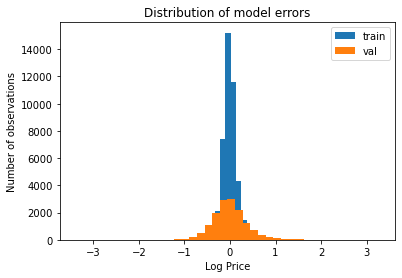

In [38]:
plt.hist(diff_train, bins=40, label='train')
plt.hist(diff_val, bins=40, label='val')
plt.title('Distribution of model errors')
plt.ylabel('Number of observations')
plt.xlabel('Log Price')
plt.legend()
plt.show()

## US & International Training Results

In [197]:
# create full train set (val + existing train)
X = pd.concat([X_train, X_val]).reset_index(drop=True)
y = pd.concat([y_train, y_val]).reset_index(drop=True)

In [198]:
# create test set
y_test = us.log_price
X_test = us.drop(columns=['log_price'])

In [200]:
# standardize data
X_test = (X_test - X_train_mean)/X_train_stdev
X_test.fillna(0, inplace=True)
X_test.replace([np.inf, -np.inf], 0, inplace=True)

In [202]:
start = time.time()
rf_final = RandomForestRegressor(n_estimators=100, min_samples_split=2, 
                                min_samples_leaf=2, max_features='auto',
                               max_depth=100, bootstrap=True).fit(X, y)
end = time.time()

In [203]:
print('Train time:', round(end - start,2))

Train time: 119.33


In [204]:
y_pred_train = rf_final.predict(X)
test_start = time.time()
y_pred = rf_final.predict(X_test)
test_end = time.time()

acc_train = rf_final.score(X, y)
acc = rf_final.score(X_test, y_test)

rmse_train = mean_squared_error(np.exp(y), np.exp(y_pred_train), squared=False)
rmse = mean_squared_error(np.exp(y_test), np.exp(y_pred), squared=False)

mae_train = mean_absolute_error(np.exp(y), np.exp(y_pred_train))
mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))

medae_train = median_absolute_error(np.exp(y), np.exp(y_pred_train))
medae = median_absolute_error(np.exp(y_test), np.exp(y_pred))

In [205]:
print('Test time:', round(test_end - test_start,2))

Test time: 0.73


In [206]:
print('R^2 (Train):', round(acc_train,2)) 
print('R^2 (Test):', round(acc,2))
print('')
print('RMSE (Train):', round(rmse_train,2))
print('RMSE (Test):', round(rmse,2))
print('')
print('Mean Abs Error (Train):', round(mae_train,2))
print('Mean Abs Error (Test):', round(mae,2))
print('')
print('Median Absolute Error (Train):', round(medae_train,2))
print('Median Absolute Error (Test):', round(medae,2))

R^2 (Train): 0.93
R^2 (Test): 0.67

RMSE (Train): 69.52
RMSE (Test): 117.3

Mean Abs Error (Train): 24.7
Mean Abs Error (Test): 51.89

Median Absolute Error (Train): 9.27
Median Absolute Error (Test): 23.53


In [59]:
# plt.hist(y_test, bins=40, label='actual')
# plt.hist(y_pred, bins=40, label='predictions')
# plt.title('Distribution of predictions versus actual')
# plt.ylabel('Number of observations')
# plt.xlabel('Log Price')
# plt.legend()
# plt.show()

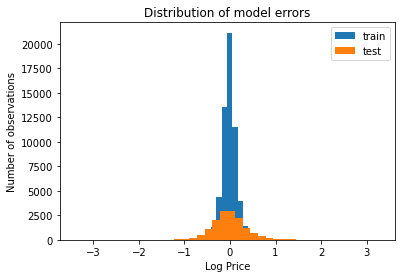

In [45]:
diff_train = y - y_pred_train
diff_test = y_test - y_pred

plt.hist(diff_train, bins=40, label='train')
plt.hist(diff_val, bins=40, label='test')
plt.title('Distribution of model errors')
plt.ylabel('Number of observations')
plt.xlabel('Log Price')
plt.legend()
plt.show()

## Import international data

In [361]:
madrid = pd.read_csv('../data/processed/madrid-test.csv')
london = pd.read_csv('../data/processed/london-test.csv')
paris = pd.read_csv('../data/processed/paris-test.csv')

In [362]:
madrid_y = madrid.log_price
madrid_X = madrid.drop(columns=['log_price'])

london_y = london.log_price
london_X = london.drop(columns=['log_price'])

paris_y = paris.log_price
paris_X = paris.drop(columns=['log_price'])

In [363]:
# standardize madrid data
madrid_X = (madrid_X - X_train_mean)/X_train_stdev
madrid_X.fillna(0, inplace=True)
madrid_X.replace([np.inf, -np.inf], 0, inplace=True)

# standardize london data
london_X = (london_X - X_train_mean)/X_train_stdev
london_X.fillna(0, inplace=True)
london_X.replace([np.inf, -np.inf], 0, inplace=True)

# standardize madrid data
paris_X = (paris_X - X_train_mean)/X_train_stdev
paris_X.fillna(0, inplace=True)
paris_X.replace([np.inf, -np.inf], 0, inplace=True)

#### Madrid

In [325]:
from sklearn.metrics import r2_score

In [364]:
madrid_col = 100/75.8
madrid_y = madrid_col*madrid_y

In [365]:
mad_start = time.time()
y_pred = rf_final.predict(madrid_X)
mad_end = time.time()

acc = rf_final.score(madrid_X, madrid_y)

rmse = mean_squared_error(np.exp(madrid_y), np.exp(y_pred), squared=False)

mae = mean_absolute_error(np.exp(madrid_y), np.exp(y_pred))

medae = median_absolute_error(np.exp(madrid_y), np.exp(y_pred))

In [366]:
print('Test Time (madrid):', round(mad_end-mad_start,2))
print('')
print('R^2 (Madrid):', round(acc,2))
print('')
print('RMSE (Madrid):', round(rmse,2))
print('')
print('Mean Abs Error (Madrid):', round(mae,2))
print('')
print('Median Absolute Error (Madrid):', round(medae,2))

Test Time (madrid): 0.72

R^2 (Madrid): 0.17

RMSE (Madrid): 7775.35

Mean Abs Error (Madrid): 870.56

Median Absolute Error (Madrid): 70.27


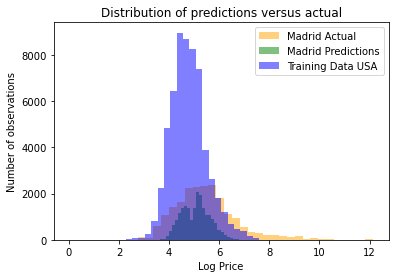

In [367]:
plt.hist(madrid_y, bins=30, label='Madrid Actual', color='orange', alpha = 0.5)
plt.hist(y_pred, bins=30, label='Madrid Predictions', color='green',alpha = 0.5)
plt.hist(y, bins=30, label='Training Data USA', color='blue', alpha = 0.5)
plt.title('Distribution of predictions versus actual')
plt.ylabel('Number of observations')
plt.xlabel('Log Price')
plt.legend()
plt.show()

#### London

In [309]:
london_col = 100/95
london_y = london_col*london_y

In [315]:
lon_start = time.time()
y_pred = rf_final.predict(london_X)
lon_end = time.time()

acc = rf_final.score(london_X, london_y)

rmse = mean_squared_error(np.exp(london_y), np.exp(y_pred), squared=False)

mae = mean_absolute_error(np.exp(london_y), np.exp(y_pred))

medae = median_absolute_error(np.exp(london_y), np.exp(y_pred))

In [316]:
print('Test Time (London):', round(lon_end-lon_start,2))
print('')
print('R^2 (London):', round(acc,2))
print('')
print('RMSE (London):', round(rmse,2))
print('')
print('Mean Abs Error (London):', round(mae,2))
print('')
print('Median Absolute Error (London):', round(medae,2))

Test Time (London): 4.6

R^2 (London): 0.45

RMSE (London): 495.1

Mean Abs Error (London): 81.63

Median Absolute Error (London): 39.6


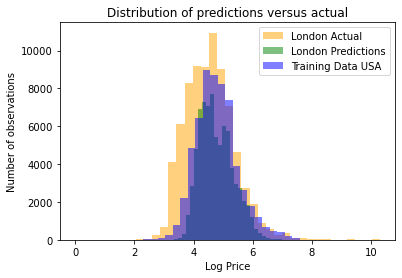

In [239]:
plt.hist(london_y, bins=30, label='London Actual', color='orange', alpha = 0.5)
plt.hist(y_pred, bins=30, label='London Predictions', color='green',alpha = 0.5)
plt.hist(y, bins=30, label='Training Data USA', color='blue', alpha = 0.5)
plt.title('Distribution of predictions versus actual')
plt.ylabel('Number of observations')
plt.xlabel('Log Price')
plt.legend()
plt.show()

#### Paris

In [368]:
france_col = 100/89.3
paris_y = france_col*paris_y

In [369]:
paris_start = time.time()
y_pred = rf_final.predict(paris_X)
paris_end = time.time()

acc = rf_final.score(paris_X, paris_y)

rmse = mean_squared_error(np.exp(paris_y), np.exp(y_pred), squared=False)

mae = mean_absolute_error(np.exp(paris_y), np.exp(y_pred))

medae = median_absolute_error(np.exp(paris_y), np.exp(y_pred))

In [370]:
print('Test Time (Paris):', round(paris_end-paris_start,2))
print('')
print('R^2 (Paris):', round(acc,2))
print('')
print('RMSE (Paris):', round(rmse,2))
print('')
print('Mean Abs Error (Paris):', round(mae,2))
print('')
print('Median Absolute Error (Paris):', round(medae,2))

Test Time (Paris): 2.36

R^2 (Paris): 0.18

RMSE (Paris): 586.81

Mean Abs Error (Paris): 114.07

Median Absolute Error (Paris): 60.71


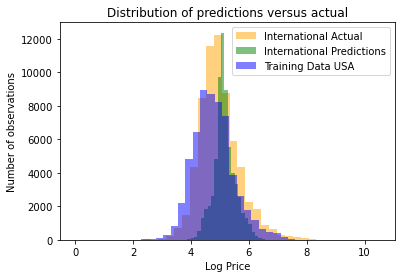

In [371]:
plt.hist(paris_y, bins=30, label='International Actual', color='orange', alpha = 0.5)
plt.hist(y_pred, bins=30, label='International Predictions', color='green',alpha = 0.5)
plt.hist(y, bins=30, label='Training Data USA', color='blue', alpha = 0.5)
plt.title('Distribution of predictions versus actual')
plt.ylabel('Number of observations')
plt.xlabel('Log Price')
plt.legend()
plt.show()

#### International

In [245]:
international_X = pd.concat([madrid_X, london_X, paris_X])
international_y = pd.concat([madrid_y, london_y, paris_y])

In [246]:
int_start = time.time()
y_pred = rf_final.predict(international_X)
int_end = time.time()

acc = rf_final.score(international_X, international_y)

rmse = mean_squared_error(np.exp(international_y), np.exp(y_pred), squared=False)

mae = mean_absolute_error(np.exp(international_y), np.exp(y_pred))

medae = median_absolute_error(np.exp(international_y), np.exp(y_pred))

In [247]:
print('Test Time (Int):', round(int_end-int_start,2))
print('')
print('R^2 (Int):', round(acc,2))
print('')
print('RMSE (Int):', round(rmse,2))
print('')
print('Mean Abs Error (Int):', round(mae,2))
print('')
print('Median Absolute Error (Int):', round(medae,2))

Test Time (Int): 6.01

R^2 (Int): 0.38

RMSE (Int): 2794.08

Mean Abs Error (Int): 191.69

Median Absolute Error (Int): 47.21


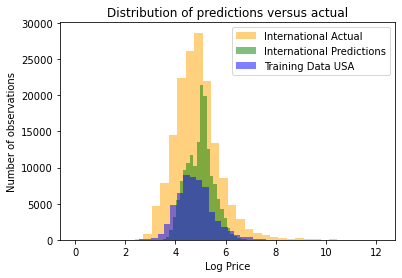

In [248]:
plt.hist(international_y, bins=30, label='International Actual', color='orange', alpha = 0.5)
plt.hist(y_pred, bins=30, label='International Predictions', color='green',alpha = 0.5)
plt.hist(y, bins=30, label='Training Data USA', color='blue', alpha = 0.5)
plt.title('Distribution of predictions versus actual')
plt.ylabel('Number of observations')
plt.xlabel('Log Price')
plt.legend()
plt.show()